In [ ]:
import cv2
import os
import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
def augment_data(images, masks, save_path, augment=True):
  H = 1024
  W = 1536
  for x,y in tqdm(zip(images, masks), total=len(images)):
    name = x.split("/")[-1].split(".")
    image_name = name[0]
    image_extn = name[1]

    name = y.split("/")[-1].split(".")
    mask_name = name[0]
    mask_extn = name[1]

    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    y = cv2.imread(y, cv2.IMREAD_COLOR)
    y = cv2.resize(y, (W, H))
    

    if augment == True:

      aug = RandomCrop(int(2*H/3), int(2*W/3), always_apply=False, p=1.0)
      augmented = aug(image=x, mask=y)
      x1 = augmented["image"]
      y1 = augmented["mask"]

      aug = HorizontalFlip(always_apply=False, p=1.0)
      augmented = aug(image=x, mask=y)
      x2 = augmented["image"]
      y2 = augmented["mask"]

      aug = VerticalFlip(always_apply=False, p=1.0)
      augmented = aug(image=x, mask=y)
      x3 = augmented["image"]
      y3 = augmented["mask"]

      save_images = [x, x1, x2, x3]
      save_masks = [y, y1, y2, y3]

    else:
      save_images = [x]
      save_masks = [y]

    idx = 0
    for i, m in zip(save_images, save_masks):
      i = cv2.resize(i, (W, H))
      m = cv2.resize(m, (W, H))

      tmp_img_name = f"{image_name}_{idx}.{image_extn}"
      tmp_msk_name = f"{mask_name}_{idx}.{mask_extn}"

      image_path = os.path.join(save_path, "images", tmp_img_name)
      mask_path = os.path.join(save_path, "masks", tmp_msk_name)

      cv2.imwrite(image_path, i)
      cv2.imwrite(mask_path, i)

      idx+=1

In [ ]:
path = "/content/drive/MyDrive/All-datasets/semantic_drone_dataset"
images = sorted(glob(os.path.join(path, "/content/drive/MyDrive/All-datasets/semantic_drone_dataset/training_set/images/*")))
masks = sorted(glob(os.path.join(path, "/content/drive/MyDrive/All-datasets/semantic_drone_dataset/training_set/gt/semantic/label_images/*")))
print(f"Original images: {len(images)} - Original masks: {len(masks)}")

Original images: 11 - Original masks: 11


In [ ]:
create_dir("/content/drive/MyDrive/new_data/images/")
create_dir("/content/drive/MyDrive/new_data/masks/")

save_path = "/content/drive/MyDrive/new_data/"

In [ ]:
augment_data(images, masks, save_path, augment=True)

images = sorted(glob(os.path.join(save_path, "images/*")))
masks = sorted(glob(os.path.join(save_path, "masks/*")))
print(f"Augmented images: {len(images)} - Augmented masks: {len(masks)}")

100%|██████████| 11/11 [00:20<00:00,  1.88s/it]

Augmented images: 44 - Augmented masks: 44


In [ ]:
image_path = os.path.join(save_path, "images/")
label_path = os.path.join(save_path, "masks/")

In [ ]:
def create_dataframe(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_images = create_dataframe(image_path)
df_masks = create_dataframe(label_path)
print('Total Images: ', len(df_images))
#print(df_images)

## Split data

X_trainval, X_test = train_test_split(df_images['id'], test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train #the same values for images (X) and labels (y)
y_test = X_test
y_val = X_val

img_train = [os.path.join(image_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(label_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(image_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(label_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(image_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(label_path, f"{name}.png") for name in y_test]

Total Images:  44
Train Size : 31 images
Val Size   :  8 images
Test Size  :  5 images


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1152, 768, 3 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 1152, 768, 32 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 1152, 768, 32 128         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 1152, 768, 32 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

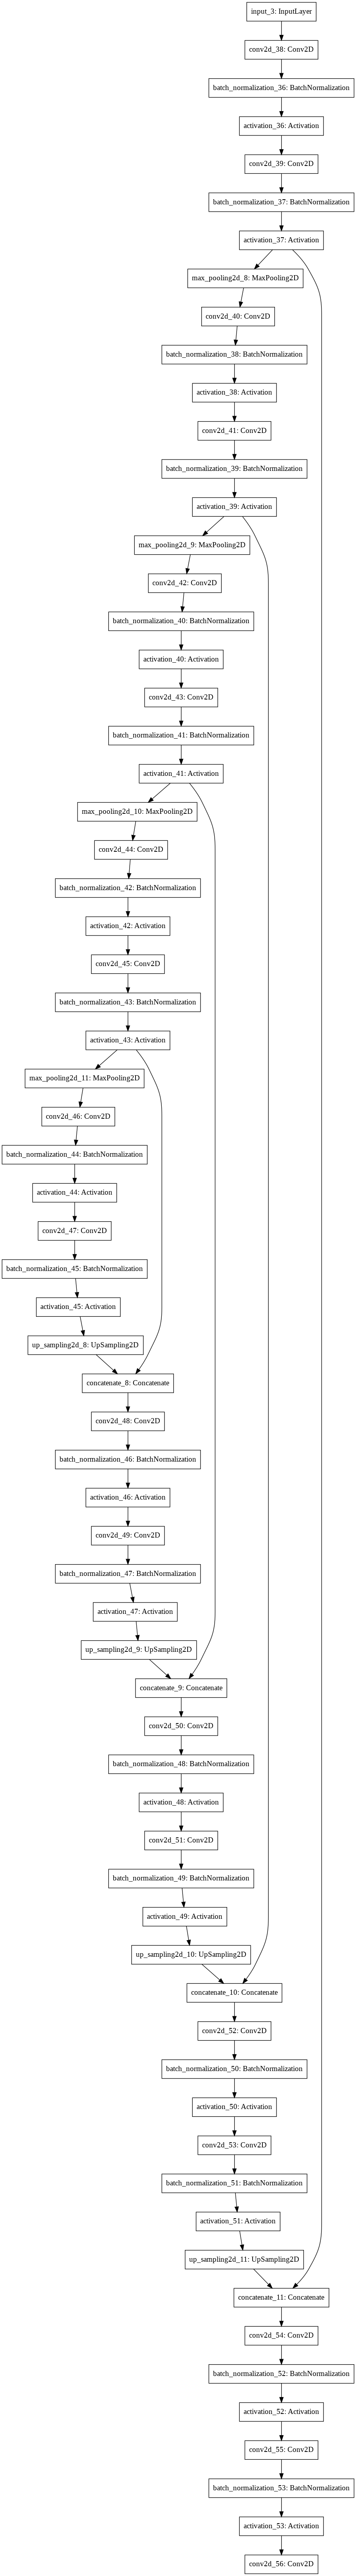

In [ ]:
def conv_block(inputs, filters, pool=True):
  x = Conv2D(filters, 3, padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  if pool == True:
    p = MaxPool2D((2, 2))(x)
    return x, p
  else:
    return x

def build_unet(shape, num_classes):
  inputs = Input(shape)

  filters_x = [32,64,96,128,128,96,64,32]
  filters_b = [256]

  #Encoder
  x1, p1 = conv_block(inputs, filters_x[0], pool=True)
  x2, p2 = conv_block(p1, filters_x[1], pool=True)
  x3, p3 = conv_block(p2, filters_x[2], pool=True)
  x4, p4 = conv_block(p3, filters_x[3], pool=True)

  #Bridge
  b1 = conv_block(p4, filters_b[0], pool=False)

  #Decoder
  u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
  c1 = Concatenate()([u1, x4])
  x5 = conv_block(c1, filters_x[4], pool=False)

  u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
  c2 = Concatenate()([u2, x3])
  x6 = conv_block(c2, filters_x[5], pool=False)

  u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
  c3 = Concatenate()([u3, x2])
  x7 = conv_block(c3, filters_x[6], pool=False)

  u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
  c4 = Concatenate()([u4, x1])
  x8 = conv_block(c4, filters_x[7], pool=False)

  output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

  return Model(inputs, output)


H = 768
W = 1152
num_classes = 3

model = build_unet((W, H, 3), num_classes)
model.summary()
plot_model(model, to_file='model.png')

In [ ]:
def read_image(x):
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (W, H))
  x = x/255.0
  x = x.astype(np.float32)
  return x

def read_mask(x):
  x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (W, H))
  x = x.astype(np.int32)
  return x

def tf_dataset(x, y, batch=4):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.shuffle(buffer_size=500)
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(2)
  return dataset

def preprocess(x, y):
  def f(x,y):
    x = x.decode()
    y = y.decode()
    image = read_image(x)
    mask = read_mask(y)
    return image, mask

  image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
  mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
  image.set_shape([H, W, 3])
  mask.set_shape([H, W, num_classes])
  return image, mask

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
shape = (H, W, 3)
num_classes = 23
lr = 1e-4
batch_size = 2
epochs = 30

In [ ]:
model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=callbacks)

Epoch 1/30
15/15 [==============================] - 977s 65s/step - loss: 0.1951 - accuracy: 0.0455 - val_loss: 0.1438 - val_accuracy: 0.0111

Epoch 00001: saving model to model.h5
Epoch 2/30
15/15 [==============================] - 896s 62s/step - loss: 0.2236 - accuracy: 0.0678 - val_loss: 0.1441 - val_accuracy: 5.0679e-04

Epoch 00002: saving model to model.h5
Epoch 3/30
15/15 [==============================] - 914s 61s/step - loss: 0.1985 - accuracy: 0.1508 - val_loss: 0.1441 - val_accuracy: 5.0396e-04

Epoch 00003: saving model to model.h5
Epoch 4/30
15/15 [==============================] - 910s 61s/step - loss: 0.1979 - accuracy: 0.1224 - val_loss: 0.1443 - val_accuracy: 5.0594e-04

Epoch 00004: saving model to model.h5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 5/30
15/15 [==============================] - 945s 63s/step - loss: 0.1992 - accuracy: 0.1171 - val_loss: 0.1444 - val_accuracy: 5.1329e-04

Epoch 00005: saving model to model.h

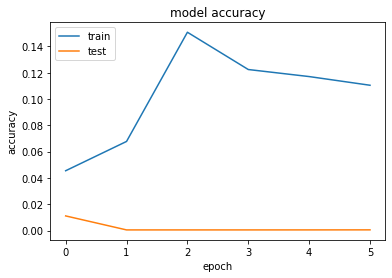

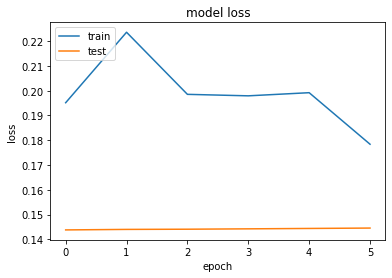

In [ ]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
create_dir('/content/drive/MyDrive/results')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
for x, y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    
    ## Read image
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)

    ## Read mask
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))
    
    y = np.expand_dims(y, axis=-1) #(384,256,1)
    
    y = y * (255/num_classes)
    y = y.astype(np.int32)
    y = np.concatenate([y, y, y], axis=2)
    
    ## Prediction
    p = model.predict(np.expand_dims(x, axis=0))[0]
    p = np.argmax(p, axis=-1)
    
    p = np.expand_dims(p, axis=-1)  
    
    p = p * (255/num_classes)
    p = p.astype(np.int32)
    p = np.concatenate([p, p, p], axis=2)
      
    cv2.imwrite(f"/content/drive/MyDrive/results/{name}", p)

100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


In [ ]:
image_list = []
mask_list = []

for x,y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    image_name = name[4]

    name = y.split("/")[-1]
    mask_name = name[4]
    
    if image_name == '0':
        image_list.append(x)
        mask_list.append(y)

## Plot 5 images to verify the accuracy in the predictions

img_selection = image_list[0:5]
mask_selection = mask_list[0:5]

for img, mask in zip(img_selection, mask_selection):
    name = img.split("/")[-1]
    x = cv2.imread(img, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))

    y = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))


    p = cv2.imread(f"/content/drive/MyDrive/results/ {name}", cv2.IMREAD_GRAYSCALE)
    p = cv2.resize(p, (W, H))

    #Plotto le tre immagini
    fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

    axs[0].imshow(x, interpolation = 'nearest')
    axs[0].set_title('image')
    axs[0].grid(False)

    axs[1].imshow(y, interpolation = 'nearest')
    axs[1].set_title('mask')
    axs[1].grid(False)

    axs[2].imshow(p)
    axs[2].set_title('prediction')
    axs[2].grid(False)